In [1]:
from dataset import *
from clustering import *
import os

import numpy as np
import pandas as pd
from compere import run_expirement
import seaborn as sns
from matplotlib import pyplot as plt
from WBMS import WBMS
from sklearn.preprocessing import StandardScaler
from compere import create_defoult_parms
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import minimize

#directory for saveing data
if not os.path.isdir('data'):
    os.mkdir('data')

# Parameter search

--------
lambda = 0.001
h = 0.30000000000000004 
--------
lambda = 0.001
h = 0.35000000000000003 
--------
lambda = 0.001
h = 0.4 
--------
lambda = 0.001
h = 0.45 
--------
lambda = 0.005
h = 0.30000000000000004 
--------
lambda = 0.005
h = 0.35000000000000003 
--------
lambda = 0.005
h = 0.4 
--------
lambda = 0.005
h = 0.45 
--------
lambda = 0.01
h = 0.30000000000000004 
--------
lambda = 0.01
h = 0.35000000000000003 
--------
lambda = 0.01
h = 0.4 
--------
lambda = 0.01
h = 0.45 
--------
lambda = 0.025
h = 0.30000000000000004 
--------
lambda = 0.025
h = 0.35000000000000003 
--------
lambda = 0.025
h = 0.4 
--------
lambda = 0.025
h = 0.45 


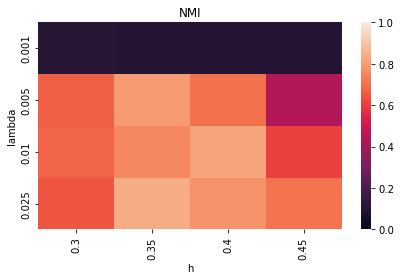

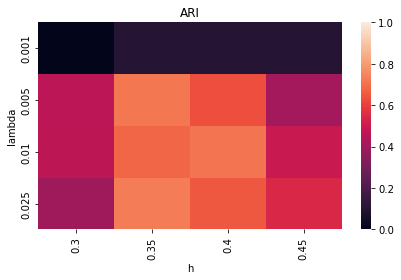

In [68]:
import warnings


def test_diff_parms(verbose=True):
    df_score = pd.DataFrame()
    #lambdas = [i * 10 if i > 0 else 5 for i in range(8)]

    datasets = [
        create_dataset_simulation(2, 2, 100, 32, 0.02, 10),
        create_dataset_simulation(3, 2, 100, 4, 0.02, 20),
        create_dataset_simulation(4, 5, 100, 5, 0.02, 30),
        create_dataset_simulation(4, 5, 100, 20, 0.02, 40),
        create_dataset_simulation(10, 4, 100, 10, 0.03,50),
        create_dataset_simulation(3, 4, 100, 30, 0.1,60),
        create_dataset_simulation(3, 4, 100, 30, 0.05,70),
        create_dataset_simulation(4, 20, 100, 20, 0.05,80),
        create_dataset_simulation(6, 10, 100, 20, 0.05,90),
        create_dataset_simulation(2, 5, 100, 20, 0.05,90),
    ]

    h_vals = [0.05 * i for i in range(6, 10)]
    for l in [1e-3, 0.005, 1e-2, 0.025]:  # lambdas:
        for h in h_vals:  # h_vals:
            if verbose:
                print('--------')
                print(f'lambda = {l}')
                print(f'h = {h} ')
            for i in range(len(datasets)):
                X, y = datasets[i]

                X_scaled = StandardScaler().fit_transform(X)

                wbms = WBMS(h=h, lambda_=l, max_iter=100)
                with warnings.catch_warnings():  # did not converge warrning just to have simplified output
                    warnings.simplefilter("ignore")
                    wbms.fit(X_scaled)
                y_pred = wbms.labels_
                nmi = normalized_mutual_info_score(y, y_pred)
                ari = adjusted_rand_score(y, y_pred)
                df_score = df_score.append(pd.Series({'NMI': nmi, 'ARI': ari, 'lambda': l, 'h': h}), ignore_index=True)

    for k in ['NMI', 'ARI']:
        df_tmp = df_score.copy()
        df_tmp = df_tmp.groupby(['lambda', 'h']).mean().reset_index()
        df_tmp = df_tmp.pivot('lambda', 'h', k)
        sns.heatmap(df_tmp,vmin=0, vmax=1)
        plt.title(k)
        labels = [item.get_text() for item in plt.gca().get_xticklabels()]
        plt.gca().set_xticklabels([str(round(float(label), 2)) for label in labels])
        plt.tight_layout()
        plt.savefig(os.path.join('figures',f'parameter_search_{k}.png'))
        plt.show()

    return df_score


df_diff_parms = test_diff_parms()

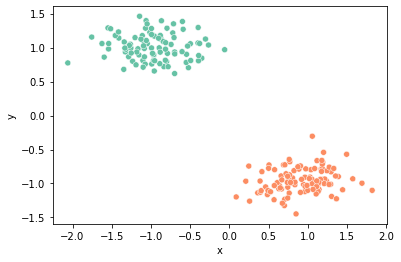

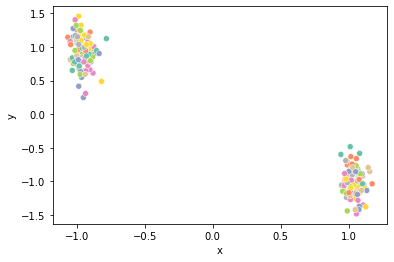

In [23]:
for i in [12, 15]:
    X, y = create_dataset_simulation(2, 2, 200, 32, 0.02, i)
    wbms = WBMS(h=0.35, lambda_=0.005)
    X = StandardScaler().fit_transform(X)
    wbms.fit(X)
    y_pred = wbms.labels_
    data_plot = pd.DataFrame({'x': X[:, 0], 'y': X[:, 1], 'c': y_pred})
    sns.scatterplot(data=data_plot, x='x', y='y', hue='c', palette='Set2', legend=False)
    plt.show()

## Simulation 1: Effect of increasing k

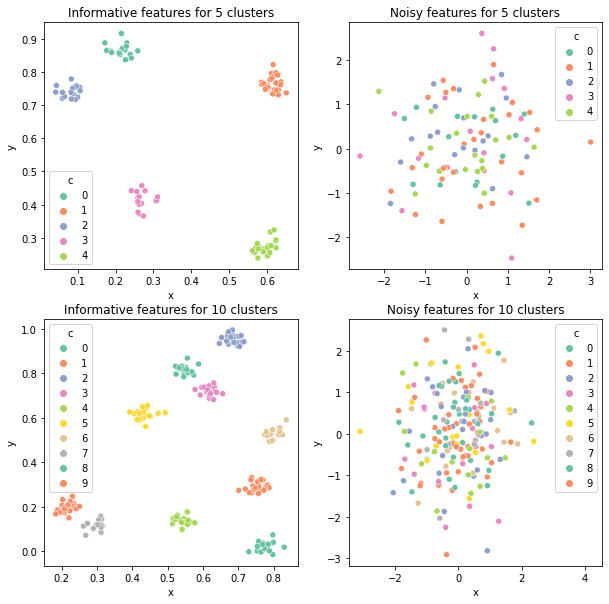

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
data = [create_dataset_simulation(k=i, n_informative_features=5, n_samples=20 * i, n_features=20, scale=.02, seed=i) for
        i
        in [5, 10]]
for i in range(2):
    data_plot = pd.DataFrame({'x': data[i][0][:, 0], 'y': data[i][0][:, 1], 'c': data[i][1]})
    sns.scatterplot(data=data_plot, x='x', y='y', hue='c', ax=ax[i, 0], palette='Set2')
    ax[i, 0].set_title(f'Informative features for {np.max(data[i][1]) + 1} clusters')
    data_plot = pd.DataFrame({'x': data[i][0][:, -2], 'y': data[i][0][:, -3], 'c': data[i][1]})
    sns.scatterplot(data=data_plot, x='x', y='y', hue='c', ax=ax[i, 1], palette='Set2')
    ax[i, 1].set_title(f'Noisy features for {np.max(data[i][1]) + 1} clusters')
plt.show()


In [7]:
def run_simulatiom_effect_of_increasing_k():
    df_scores = pd.DataFrame()
    for c in [5, 10, 20, 30, 40, 50]:
        print(f'Data with  {c} clusters')
        for i in range(10):
            X, y = create_dataset_simulation(c, 5, 20 * c, 20, 0.02, i+1000)
            #should data be scaled?
            #print('optimal k hardcoded')
            optimalK = -1  #OptimalK(n_jobs=4, parallel_backend='joblib')(X,cluster_array=np.arange(1, 5*c))
            #print(f'Optimal k ={optimalK}')
            df = pd.DataFrame(X)
            #assert np.all(np.isclose(X,df.to_numpy()))
            df['label'] = y

            parms = create_defoult_parms(optimalK)

            df_res, nmi, ari, n_clust = run_expirement(df, optimalK, parms, verbose=False,
                                                       run=['wbms', 'wbms_authors'])
            nmi['type'] = 'NMI'
            ari['type'] = 'ARI'
            n_clust['type'] = 'n_clusters'
            nmi['# Clusters'] = c
            ari['# Clusters'] = c
            n_clust['# Clusters'] = c
            df_scores = df_scores.append(pd.Series(nmi), ignore_index=True)
            df_scores = df_scores.append(pd.Series(ari), ignore_index=True)
            df_scores = df_scores.append(pd.Series(n_clust), ignore_index=True)

    df_long_format = df_scores.melt(id_vars=['type', '# Clusters'])
    for t in ['NMI', 'ARI', 'n_clusters']:
        sns.lineplot(data=df_long_format[df_long_format.type == t], x='# Clusters', y='value', hue='variable')
        plt.ylabel(t)
        if t == 'n_clusters':
            plt.ylim(0, 60)
        plt.show()

    return df_scores


In [8]:
df_effect_of_increasing_k = run_simulatiom_effect_of_increasing_k()

Data with  5 clusters


D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.007507933262457467
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')
D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.0013844055233525054
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')


Data with  10 clusters


D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.00038089402302121655
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')
D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.00019560828355658089
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')


Data with  20 clusters


D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.0002084923719585241
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')


Data with  30 clusters
Data with  40 clusters


KeyboardInterrupt: 

Data with  2 clusters
Data with  3 clusters
Data with  4 clusters


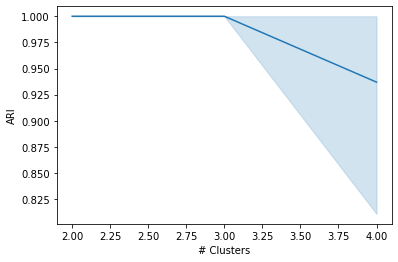

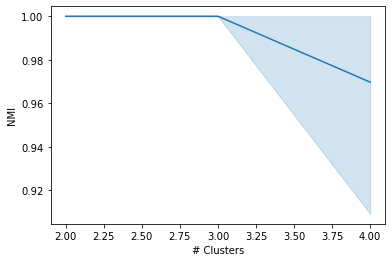

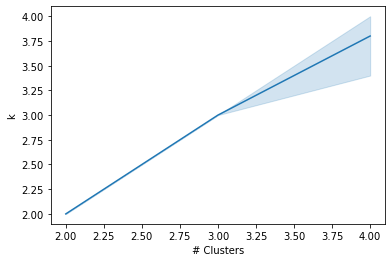

In [3]:
def run_simulatiom_on_g_means():
    df_scores = pd.DataFrame()
    for c in [2,3,4]:#[5, 10, 20]:  #, 30, 40, 50]:
        print(f'Data with  {c} clusters')
        for i in range(5):
            X, y = create_dataset_simulation(c, 5, 20 * c, 5, 0.02, i)

            #should data be scaled?
            #print('optimal k hardcoded')
            optimalK = -1  #OptimalK(n_jobs=4, parallel_backend='joblib')(X,cluster_array=np.arange(1, 5*c))
            #print(f'Optimal k ={optimalK}')
            X = StandardScaler().fit_transform(X)
            #y_pred = get_clusters_wbms(X,0.35,0.01,50)
            #data_path = os.path.join('data', 'tmp_wbms.csv')
            #pd.DataFrame(X).to_csv(data_path,index=False)
            h,l = 0.3,0.05


            y_pred = get_clusters_wbms(X, h=h,lambda_=l)

            ari = adjusted_rand_score(y, y_pred)
            nmi = normalized_mutual_info_score(y, y_pred)
            n_clusters = np.max(y_pred) + 1
            df_scores = df_scores.append(pd.Series({'ARI': ari, 'NMI': nmi, '# Clusters': c, 'k': n_clusters}),
                                         ignore_index=True)
            #data_plot = pd.DataFrame({'x': X[:, 0], 'y': X[:, 1], 'c': y_pred})
            #sns.scatterplot(data=data_plot, x='x', y='y', hue='c', palette='Set2')
            #plt.show()

            #print(df_scores)

    sns.lineplot(x='# Clusters', y='ARI', data=df_scores)
    plt.show()
    sns.lineplot(x='# Clusters', y='NMI', data=df_scores)
    plt.show()
    sns.lineplot(x='# Clusters', y='k', data=df_scores)
    plt.show()

    return df_scores


df_run_simulatiom = run_simulatiom_on_g_means()

## Simulation 3: Feature Selection

Example of 2 datasets that are used. In left column there are two importa features and in right column there is noisy feature.

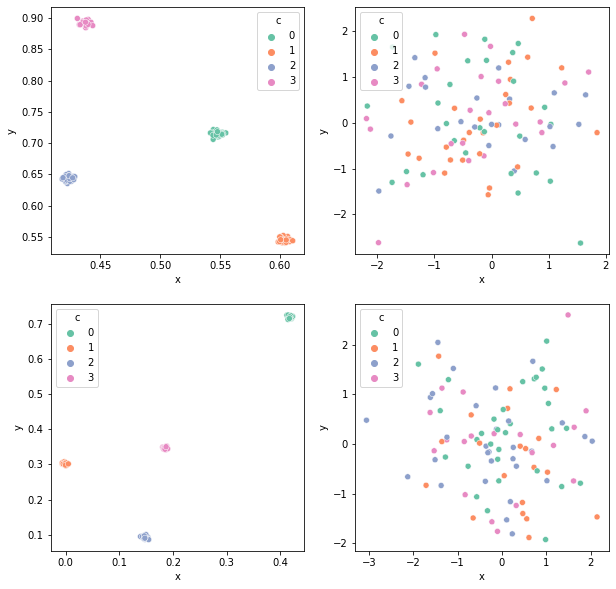

In [2]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
data = [create_dataset_simulation(k=4, n_informative_features=2, n_samples=100, n_features=10, scale=.003, seed=i) for i
        in range(2)]
for i in range(2):
    data_plot = pd.DataFrame({'x': data[i][0][:, 0], 'y': data[i][0][:, 1], 'c': data[i][1]})
    sns.scatterplot(data=data_plot, x='x', y='y', hue='c', ax=ax[i, 0], palette='Set2')

    data_plot = pd.DataFrame({'x': data[i][0][:, 2], 'y': data[i][0][:, 3], 'c': data[i][1]})
    sns.scatterplot(data=data_plot, x='x', y='y', hue='c', ax=ax[i, 1], palette='Set2')
plt.show()


D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.0029272541220790593
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')
D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.00016673656860444197
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')
D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.0005798025859578004
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')
D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.0017831858313588356
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')


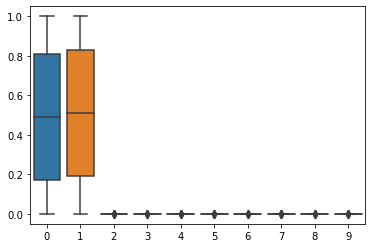

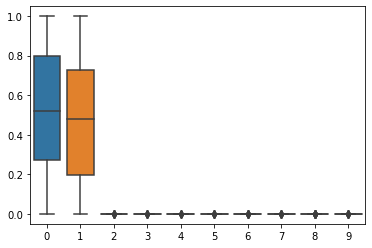

In [9]:
def test_feature_weights():
    df = pd.DataFrame()
    df_author = pd.DataFrame()
    data_path = os.path.join('data', 'tmp_wbms.csv')
    for i in range(100):
        X, y = create_dataset_simulation(k=4, n_informative_features=2, n_samples=100, n_features=10, scale=.003,
                                         seed=i)

        X = StandardScaler().fit_transform(X)

        pd.DataFrame(X).to_csv(data_path, index=False)
        c, w = get_clusters_wbms_R(data_path, 0.1, 10, True, False)
        df_author = df_author.append(pd.Series(w), ignore_index=True)

        wbms = WBMS(h=0.35, lambda_=0.1, max_iter=100)
        wbms.fit(X)

        df = df.append(pd.Series(wbms.w_), ignore_index=True)

    sns.boxplot(data=df)
    plt.show()
    sns.boxplot(data=df_author)
    plt.show()
    return df, df_author


df_ours_feature_weights, df_author_feature_weights = test_feature_weights()

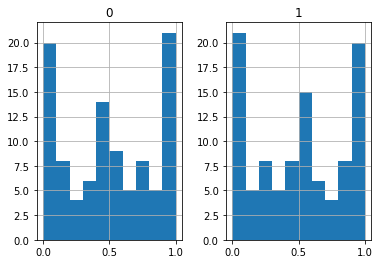

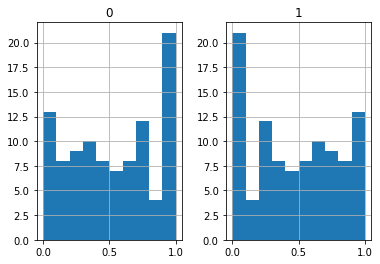

In [10]:
df_ours_feature_weights[[0, 1]].hist()
plt.show()
df_author_feature_weights[[0, 1]].hist()
plt.show()

In [ ]:
def run_real_data():
    name_f_pair = [('appendicitis', read_appendicitis),
                   ('GCM', read_gcm),
                   ('mammographic', read_mammographic),
                   ('movement_libras', read_movement_libras),
                   ('nci9', read_nci9),
                   ('yale', read_yale),
                   ('zoo', read_yale),
                   ]
    df_scores = pd.DataFrame(columns=['kmeans', 'gmeans', 'mean_shift', 'rcc',
                                      'ewdp', 'dp_means', 'wgmeans', 'wbms'])
    for name, f_read in name_f_pair:
        print('Start dataset', name, '...')
        df = f_read()
        df_res, nmi, ari, n_clust = run_expirement(df)
        df_scores = df_scores.append(pd.Series(nmi, name=(name, 'NMI')))
        df_scores = df_scores.append(pd.Series(ari, name=(name, 'ARI')))
        # df_scores = df_scores.append(pd.Series(ami, name=(name, 'AMI')))
    return df_scores

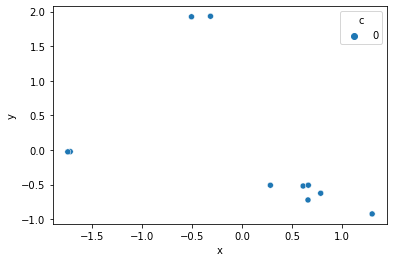

In [4]:
X, y = create_dataset_simulation(5, 5, 10, 20, 0.02, 13)

X = StandardScaler().fit_transform(X)

pd.DataFrame(X).to_csv(os.path.join('data', 'tmp_data.csv'), index=False)
y_pred = get_clusters_wbms_R(os.path.join('data', 'tmp_data.csv'), h=0.1, lambda_=10, verbose=False)
#wbms.fit(X)
#y_pred = wbms.labels_
nmi = normalized_mutual_info_score(y, y_pred)
ari = adjusted_rand_score(y, y_pred)
data_plot = pd.DataFrame({'x': X[:, 0], 'y': X[:, 1], 'c': y_pred})
sns.scatterplot(data=data_plot, x='x', y='y', hue='c')
plt.show()

In [29]:
def evaluate_clustering(parms, *args):
    h, lambda_ = parms
    scores = []
    for X, y in args[0]:
        X = StandardScaler().fit_transform(X)
        wbms = WBMS(h=h, lambda_=lambda_)
        wbms.fit(X, y)
        y_pred = wbms.labels_
        nmi = normalized_mutual_info_score(y, y_pred)
        ari = adjusted_rand_score(y, y_pred)
        scores.append(-(nmi + ari) / 2)  # we are minimizing
    return np.mean(scores)

In [30]:
parms = minimize(evaluate_clustering, x0=np.array([0.1, 0.1]),
                 args=[create_dataset_simulation(4, 2, 100, 5, 0.01, seed=100 + i) for i in range(10)],
                 method='Nelder-Mead', bounds=[(1e-15, None), (1e-15, None)], options={'disp': True, 'maxiter': 100})
print(parms)
print(f'opt h is {parms.x[0]}')
print(f'opt lambda is {parms.x[1]}')

Optimization terminated successfully.
         Current function value: -0.244133
         Iterations: 12
         Function evaluations: 35
 final_simplex: (array([[0.11      , 0.095     ],
       [0.11      , 0.09507812],
       [0.11001953, 0.0950293 ]]), array([-0.24413306, -0.24413306, -0.24413306]))
           fun: -0.24413305802238625
       message: 'Optimization terminated successfully.'
          nfev: 35
           nit: 12
        status: 0
       success: True
             x: array([0.11 , 0.095])
opt h is 0.11000000000000001
opt lambda is 0.095


In [48]:
parms = minimize(evaluate_clustering, x0=np.array([0.3, 0.01]),
                 args=[create_dataset_simulation(4, 2, 100, 5, 0.01, seed=100 + i) for i in range(10)],
                 method='Nelder-Mead', bounds=[(1e-15, None), (1e-15, None)], options={'disp': True, 'maxiter': 50,'initial_simplex':np.array([
        [0.3,0.01],[0.1,0.001],[0.15,0.05]
    ])})

D:\GitRepositories\FeatureWeightedMeanShiftAlgorithm\WBMS.py:89: UserWarning: Did not covrge. Convege_con is 0.0005129393018137307
  warnings.warn(f'Did not covrge. Convege_con is {converge_con}')


KeyboardInterrupt: 

In [ ]:
parms

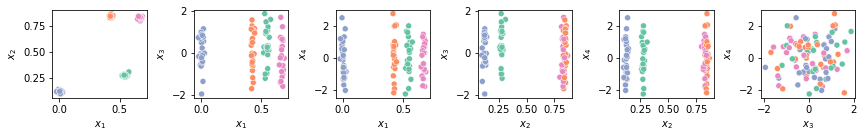

In [65]:
X,y = create_dataset_simulation(4, 2, 100, 4, 0.01, seed=100 )
#X = StandardScaler().fit_transform(X)
df_plot = pd.DataFrame({f'x_{i+1}':X[:,i] for i in range(4)})
df_plot['cluster']= y

fif,axs = plt.subplots(1,6,figsize=(12,2))


sns.scatterplot(data=df_plot,x='x_1',y='x_2',hue='cluster',ax=axs[0],palette='Set2',legend=False)
sns.scatterplot(data=df_plot,x='x_1',y='x_3',hue='cluster',ax=axs[1],palette='Set2',legend=False)
sns.scatterplot(data=df_plot,x='x_1',y='x_4',hue='cluster',ax=axs[2],palette='Set2',legend=False)
sns.scatterplot(data=df_plot,x='x_2',y='x_3',hue='cluster',ax=axs[3],palette='Set2',legend=False)
sns.scatterplot(data=df_plot,x='x_2',y='x_4',hue='cluster',ax=axs[4],palette='Set2',legend=False)
sns.scatterplot(data=df_plot,x='x_3',y='x_4',hue='cluster',ax=axs[5],palette='Set2',legend=False)
plt.tight_layout()
for a in axs:
    a.set_xlabel(f'${a.get_xlabel()}$')
    a.set_ylabel(f'${a.get_ylabel()}$')
#plt.savefig(os.path.join('figures','DGP.png'))